In [1]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, recall_score, precision_score, f1_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

import os
import matplotlib.pyplot as plt
import seaborn as sns
import time
import csv
import pandas as pd


#load the preprocessed data
X_train = pd.read_csv("X_train_multi.csv")
X_test = pd.read_csv("X_test_multi.csv")
y_train = pd.read_csv("y_train_multi.csv").squeeze()
y_test = pd.read_csv("y_test_multi.csv").squeeze()

In [2]:
#dataframes to tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

In [3]:
#Load the data to gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

In [4]:
num_classes = 11
num_layers = 3
hidden_sizes = [120, 92, 67]
dropout = 0.22675761337411485
lr = 0.0008396370943424193
batch_size = 1024
optimizer_name = 'Adam'  # Using Adam optimizer as per the params
num_epoch = 25

In [5]:
# Define model architecture
layers = []
in_features = X_train.shape[1]  # This should be defined earlier in your code

for i in range(num_layers):
    out_features = hidden_sizes[i]
    layers.append(nn.Linear(in_features, out_features))
    layers.append(nn.ReLU())
    layers.append(nn.Dropout(dropout))
    in_features = out_features

layers.append(nn.Linear(in_features, num_classes))  # Output layer

mlp_model = nn.Sequential(*layers).to(device)  # Ensure `device` is defined, e.g., torch.device("cuda" or "cpu")

In [6]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [7]:
#define loss function for binary classification
loss_fn = nn.CrossEntropyLoss()

# Create the optimizer based on the variable `optimizer_name`
if optimizer_name == "Adam":
    optimizer = optim.Adam(mlp_model.parameters(), lr=lr)
elif optimizer_name == "SGD":
    optimizer = optim.SGD(mlp_model.parameters(), lr=lr)
elif optimizer_name == "RMSprop":
    optimizer = optim.RMSprop(mlp_model.parameters(), lr=lr)
else:
    raise ValueError(f"Unsupported optimizer: {optimizer_name}")

In [8]:
#train and test sets loaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [9]:
start_time = time.perf_counter()
for epoch in range(num_epoch):
    mlp_model.train()
    for inputs, labels in train_loader:
        inputs = inputs.view(inputs.size(0), -1).to(device)
        labels = labels.to(device)

        # clear gradients from previous step
        optimizer.zero_grad()
        outputs = mlp_model(inputs)

        loss = loss_fn(outputs, labels)

        #compute gradients of the loss
        loss.backward()
        #compute gradients of the loss
        optimizer.step()

end_time = time.perf_counter()
training_time = end_time - start_time
print(f"\nTraining (convergence) time: {training_time} seconds")


Training (convergence) time: 265.3383545000106 seconds


In [10]:
# Collect predictions and labels
all_labels = []
all_preds = []

mlp_model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.view(inputs.size(0), -1).to(device)
        outputs = mlp_model(inputs)  # shape: [batch_size, num_classes]

        preds = torch.argmax(outputs, dim=1)  # predicted class indices
        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu())

In [11]:
# Convert to numpy arrays
y_pred = torch.cat(all_preds).numpy()
y_true = torch.cat(all_labels).numpy()

In [12]:
#calculate metrics
accuracy = accuracy_score(y_true, y_pred)
recall = recall_score(y_true, y_pred, average='macro')
precision = precision_score(y_true, y_pred, average='macro',zero_division=0)
f1 = f1_score(y_true, y_pred, average='macro')

print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"F1 Score: {f1}")

Accuracy: 0.9995594038542585
Recall: 0.802414620766049
Precision: 0.9057341546936684
F1 Score: 0.8286485197180301


In [13]:
print("\nClassification Report:")
print(classification_report(y_true, y_pred, zero_division=0))


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    242754
           1       1.00      1.00      1.00      9676
           2       1.00      1.00      1.00      9331
           3       1.00      1.00      1.00     34296
           4       1.00      1.00      1.00     14377
           5       1.00      0.98      0.99      2094
           6       0.97      1.00      0.98       558
           7       1.00      0.98      0.99        83
           8       1.00      0.23      0.38        26
           9       1.00      0.64      0.78        14
          10       0.00      0.00      0.00         3

    accuracy                           1.00    313212
   macro avg       0.91      0.80      0.83    313212
weighted avg       1.00      1.00      1.00    313212



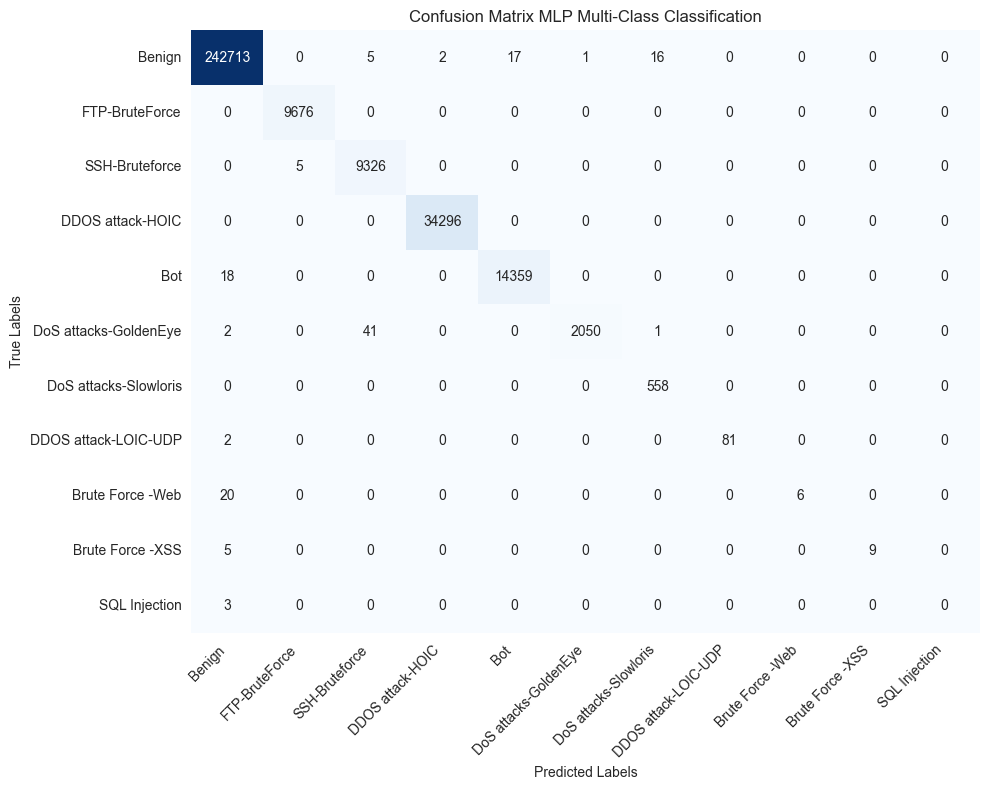

In [14]:
# List of class labels in the correct order
labels = [
    'Benign',
    'FTP-BruteForce',
    'SSH-Bruteforce',
    'DDOS attack-HOIC',
    'Bot',
    'DoS attacks-GoldenEye',
    'DoS attacks-Slowloris',
    'DDOS attack-LOIC-UDP',
    'Brute Force -Web',
    'Brute Force -XSS',
    'SQL Injection'
]

# Compute confusion matrix with string labels
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',xticklabels=labels, yticklabels=labels, cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix MLP Multi-Class Classification')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [15]:
#export results
#xgb_best_multi
results_list = ["mlp_multi", training_time, accuracy, recall, precision, f1, None, None, None, None, None, None]
file_path = 'results.csv'

# Check if the file exists to avoid duplicate headers
file_exists = os.path.isfile(file_path)

# Open and write to the file
with open(file_path, mode='a', newline='') as file:
    writer = csv.writer(file)

    # Write the data row
    writer.writerow(results_list)